In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
from PIL import Image
import glob
from utils import *
from tqdm import tqdm
from sklearn.model_selection import train_test_split

## Prepare data

### Gather Data from Structure

In [2]:
mat_files = glob.glob('./dataset/Data/Normalized/**/*.mat', recursive=True)
mat_files.sort()

In [3]:
index, image, pose, gaze = gather_all_data('./dataset/Data/Normalized')

100%|██████████| 521/521 [00:13<00:00, 38.78it/s]


In [4]:
image = image / 255
gaze = gaze3Dto2D(gaze)
pose = pose3Dto2D(pose)

In [ ]:
random_state = 42
image_train, image_test, pose_train, pose_test, gaze_train, gaze_test = train_test_split(image, pose, gaze,
                                            stratify=index[:, [0, -1]],
                                            test_size=0.33,
                                            random_state=random_state)

In [67]:
def print_shapes(titles, items):
    for title, item in zip(titles, items):
        print((title+':').ljust(15) + str(item.shape))

print_shapes(['Indices', 'Images', 'Poses', 'Gazes'], (indices, images, poses, gazes))

Indices:       (427316, 4)
Images:        (427316, 36, 60, 1)
Poses:         (427316, 3)
Gazes:         (427316, 3)


In [7]:
print_shapes(['Indices', 'Images', 'Angle Poses', 'Angle Gazes'], (indices, images, angle_poses, angle_gazes))

Indices:       (427316, 4)
Images:        (427316, 36, 60, 1)
Angle Poses:   (427316, 2)
Angle Gazes:   (427316, 2)


### Check

In [56]:
(images[i] / 255).dtype

dtype('float64')

['p00' 'day01' '0001.jpg']


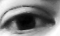

In [30]:
i = 0
print(indices[i])
Image.fromarray(images[i].reshape((36, 60)))

In [37]:
angle_poses[0]

array([ 0.24219653,  0.15265545], dtype=float32)

In [49]:
angle_poses[0]

array([ 0.11936873,  0.15265545], dtype=float32)

## Create NN

In [18]:
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Concatenate, Flatten
from keras.initializers import RandomNormal
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.models import Model

Using TensorFlow backend.


### Layers

In [19]:
# input
input_img = Input(shape=(36, 60, 1), name='InputNormalizedImage')
input_pose = Input(shape=(2,), name='InputHeadPose')

# convolutional
conv1 = Conv2D(filters=20,
               kernel_size=(5, 5),
               strides=(1, 1),
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.1, seed=None),
               bias_initializer='zeros',
               name='conv1'
              )(input_img)
pool1 = MaxPool2D(pool_size=(2, 2),
                  strides=(2, 2),
                  padding='valid',
                  name='maxpool1'
                 )(conv1)
conv2 = Conv2D(filters=50,
               kernel_size=(5, 5),
               strides=(1, 1),
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.01, seed=None),
               bias_initializer='zeros',
               name='conv2'
              )(pool1)
pool2 = MaxPool2D(pool_size=(2, 2),
                  strides=(2, 2),
                  padding='valid',
                  name='maxpool2'
                 )(conv2)

flatt = Flatten(name='flatt')(pool2)

# inner product 1
dense1 = Dense(units=500,
              activation='relu',
              kernel_initializer='glorot_uniform',
              bias_initializer='zeros',
              name='ip1'
             )(flatt)

# concatanate with head pose
cat = Concatenate(axis=-1, name='concat')([dense1, input_pose])

# inner product 2
dense2 = Dense(units=2,
              kernel_initializer='glorot_uniform',
              bias_initializer='zeros',
              name='ip2'
             )(cat)

### Loss function

In [20]:
def loss(target, predicted):
    return np.mean(np.sqrt(np.sum((target - predicted) ** 2, axis=1)))

### Compile

In [22]:
model = Model([input_img, input_pose], dense2)
model.compile(optimizer='adam', loss=loss)

AxisError: axis 1 is out of bounds for array of dimension 0

### Callback

In [10]:
tbCallBack = TensorBoard(log_dir='./log',
                         histogram_freq=0,
                         write_graph=True,
                         write_images=True)

### Train

In [11]:
model.fit(x=[images, angle_poses], y=angle_gazes,
          batch_size=1000,
          shuffle=True,
          epochs=3,
          validation_split=0.3,
          callbacks=[tbCallBack])

Train on 149560 samples, validate on 64098 samples
Epoch 1/3
149560/149560 [==============================] - 533s 4ms/step - loss: 2325.2116 - val_loss: 23.0804
Epoch 2/3
149560/149560 [==============================] - 543s 4ms/step - loss: 31.7360 - val_loss: 9.2443
Epoch 3/3
149560/149560 [==============================] - 551s 4ms/step - loss: 4.2522 - val_loss: 6.9708


In [4]:
2325.2116/149560

0.015547015244717839

In [6]:
23.0804/64098

0.00036007987768729135